In [1]:
import scipy.io
import numpy as np
from sklearn.metrics import accuracy_score
import functional as F
import utils as ut
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


start_time = time.time()
data = scipy.io.loadmat('../data/TsukubaHandSize24x24.mat')
data = data['data']

train_data, test_data = ut.split_train_test(data)
train_data = ut.reshape_data(train_data, 80)
test_data = ut.reshape_data(test_data, 20)

train_data = ut.split_and_reshape(train_data)
test_data = ut.split_and_reshape(test_data)

# plot train images
# first_images = [cls_arr[:, :, 0] for cls_arr in X_train]
# plot_first_images(first_images)

# # plot test images
# first_images = [cls_arr[:, :, 0] for cls_arr in X_test]
# plot_first_images(first_images)

train_data = ut.flatten_and_transpose(train_data)
test_data = ut.flatten_and_transpose(test_data)

print('Train data shape ',np.array(train_data).shape)
print('Test data shape ',np.array(test_data).shape)

# Fianl preparation of the dataset
NUM_OF_CLASSES = 30
NUM_OF_SETS = 3

X_train = [_X.T for _X in train_data]  # transpose into (N=896, M=30)

test_sets = []

for test_class in test_data:
    test_sets.extend(np.array_split(test_class, NUM_OF_SETS))

X_test = [_X.T for _X in test_sets]
y_test = []

for i, _ in enumerate(range(NUM_OF_CLASSES)):
    y_test.extend(NUM_OF_SETS * [i])  # add corresponding labels into y_test


# Creating the reference subspace
n_dims = 10
ref_subspaces = [F.kmsm(_X, n_dims=n_dims) for _X in X_train]
ref_subspaces = np.array(ref_subspaces)
print(f"Reference subspaces tensor shape: {ref_subspaces.shape}")


# Create the input subpsace
input_subspaces = [F.kmsm(set, n_dims=n_dims) for set in X_test]
print(f"Input subspaces shape: {input_subspaces[0].shape}")
print(f"Input subspaces len: {len(input_subspaces)}")

# Calculate the similarities of the input and the reference subspaces
similarities = np.array(
    [
        F.canonical_similarity(ref_subspaces, input_subspace)
        for input_subspace in input_subspaces
    ]
)
predictions = np.argmax(similarities, axis=1)


acc = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Binarize the output for multiclass log loss and roc auc score
y_test_bin = label_binarize(y_test, classes=[i for i in range(NUM_OF_CLASSES)])
predictions_bin = label_binarize(predictions, classes=[i for i in range(NUM_OF_CLASSES)])

logloss = log_loss(y_test_bin, predictions_bin)
roc_auc = roc_auc_score(y_test_bin, predictions_bin, multi_class='ovr')

conf_matrix = confusion_matrix(y_test, predictions)

end_time = time.time()

elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)

print("Time took: {:0>2}:{:05.2f}".format(int(minutes), seconds))
print(f"MSM accuracy: {acc * 100:.2f}")
print(f"MSM precision: {precision * 100:.2f}")
print(f"MSM recall: {recall * 100:.2f}")
print(f"MSM f1-score: {f1 * 100:.2f}")
print(f"MSM log-loss: {logloss:.2f}")
print(f"MSM ROC AUC score: {roc_auc:.2f}")

fig, ax = plt.subplots(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=range(NUM_OF_CLASSES)).plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Train data shape  (30, 33600, 576)
Test data shape  (30, 8400, 576)
Reference subspaces tensor shape: (30, 576, 10)


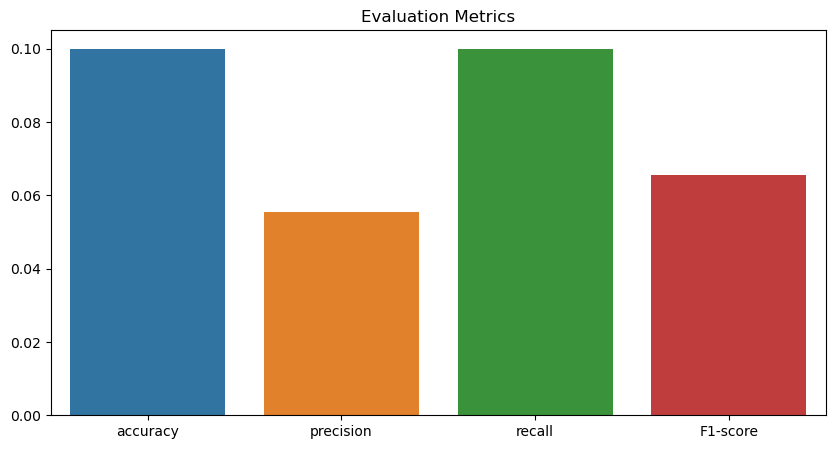

In [ ]:
metrics = [acc, precision, recall, f1]
metric_names = ["accuracy", "precision", "recall", "F1-score"]

plt.figure(figsize=(10, 5))
sns.barplot(x=metric_names, y=metrics)
plt.title('Evaluation Metrics')
plt.show()